# Investigating Fandango Movie Ratings

### Is Fandango Still Inflating Ratings?

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis [in this article](https://fivethirtyeight.com/features/fandango-movies-ratings/).

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.


In [2]:
from IPython.display import Image
# Image(filename='s1gp_fdg_stars.png')

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

* The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
* In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
* For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.


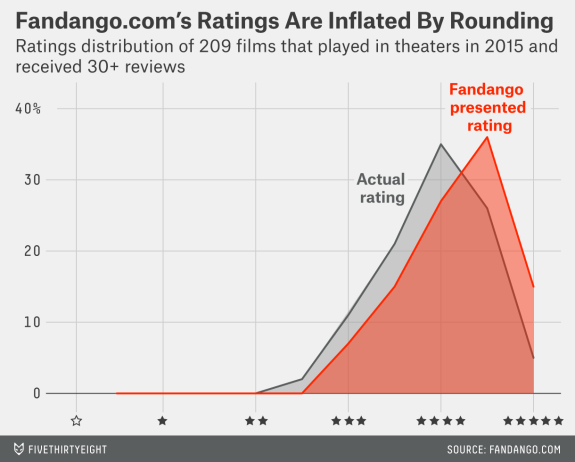

In [3]:
from IPython.display import Image
Image(filename='s1gp_actual_vs_displayed.png')

Both distributions above are strongly left skewed, suggesting that movie ratings on Fandango are generally high or very high. We can see there's no rating under 2 stars in the sample Hickey analyzed. The distribution of displayed ratings is clearly shifted to the right compared to the actual rating distribution, suggesting strongly that Fandango inflates the ratings under the hood.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

### In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

### Understanding the data

In order to understand whether there has been a change in Fandango's rating system after Hickey's analysis, we will need to compare the system as it was before and after his article.

I will use the data that Walt Hickey analyzed and made publicly available on [GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango) to analyze the characteristics of Fandango's rating system *previous* to his analysis.

I will use  movie ratings data for movies released in 2016 and 2017 that one of [Dataquest's team members collected](https://github.com/mircealex/Movie_ratings_2016_17) to analyze the rating system's characteristics *after* Hickey's analysis.

In [4]:
import pandas as pd
pd.options.display.max_columns = 100  # Avoid having displayed truncated output

previous = pd.read_csv('fandango_score_comparison.csv')
after = pd.read_csv('movie_ratings_16_17.csv')

In [5]:
previous.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,1.10,2.35,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,1.45,1.70,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [6]:
after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


We isolate the columns that offer information about Fandango's ratings in separate variables so we have just the data we're interested in more readily available for later use.

  * For the data set with ratings previous to Hickey's analysis, select the following columns: 'FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference'.
  * For the other data set, select the the following columns: 'movie', 'year', 'fandango'.


In [7]:
fandango_previous = previous[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
                             'Fandango_Difference']].copy()
fandango_after = after[['movie', 'year', 'fandango']].copy()

In [8]:
fandango_previous.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [9]:
fandango_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. Therefore the **population** of interest for our analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year.

By reading the two `README.md` files of the two repositories, we try to understand whether the two samples are representative of the population.

From Hickey's article and from the [README.md](https://github.com/fivethirtyeight/data/tree/master/fandango) the repository, we can see that he used the following sampling criteria:

  * The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
  * The movie must have had tickets on sale in 2015.


This sample does not look like representative for the entire pouplation and not random. In fact, for example, movies with less than 30 fan rating had not chance to be included. Moreover there is the temporal constraint, by selecting only 2015, we are considering  the possibility that a movie might be more (or less) popular on another year.

The sampling criteria for the other repository, as we can see from the relevant `README.md` file, are the following: 

  * The movie must have been released in 2016 or later.
  * The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).

This second sample is also subject to temporal trends and therefore unlikely to be representative of our population of interest.

### Changing the Goal of our Analysis

Because our samples are not representative of the population, we have at least two alternatives: either we collect new data, or we change the goal of our analysis by placing some limitations on it. 

The second option looks much faster as compared to collecting new data. In particular in our case it is almost impossible to collect new sample previous to Hickey's analysis at this moment in time.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal, which was to determine whether there has been any change in Fandango's rating system after Hickey's analysis. By changing our goal, our samples are now representative of the population.

### Isolating the Samples We Need

For our new goal, the two populations that we want to describe and compare are:


  * All Fandango's ratings for popular movies released in 2015.
  * All Fandango's ratings for popular movies released in 2016.


We need to define what we mean for `popular` in prder to avoid ambiguity. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as `popular` only if it has 30 fan ratings or more on Fandango's website.

The second sample however, doesn't provide information about the number of fan ratings. We should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

One way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

Unfortunately this is not possible at the moment because it looks like that at the time of writing (November 2020) Fandango website is not displaying their own reviews anymore, and it is using Rotten Tomatoes'reviews. Therefore we will just assume that all the movies in the second sample had at least 30 reviews on Fandango at the time the data set was compiled. 

We also double check that indeed there are no movies with less than 30 reviews in the first dataset, even if we know that this was one of the selection criteria, therefore we are confident that this is the case.

In [10]:
sum(fandango_previous['Fandango_votes'] < 30)

0

In the datasets there are movies with a releasing year different than 2015 or 2016. We'll need to isolate only the movies released in 2015 and 2016 in two different data sets in order to answer our questions.

For the Hickey's data set there is no specific column for the year, and we will need it to exrtact the year from the `FILM` column and add the year to a new column.

In [11]:
fandango_previous.head(1)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5


In [12]:
fandango_previous['Year'] = fandango_previous['FILM'].str[-5:-1]

We check the frequency distribution for the `Year` column and then isolate the movies released in 2015.


In [13]:
fandango_previous['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [14]:
fandango_2015 = fandango_previous[fandango_previous['Year'] == '2015'].copy()
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

We now isolate the 2015 movies from the other data set, which already has a `year` column.

In [15]:
fandango_after.head(1)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5


In [16]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [17]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

### Comparing Distribution Shapes for 2015 and 2016

Our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. In order answer this question, we start by comparing the distributions of movie ratings for the two samples.

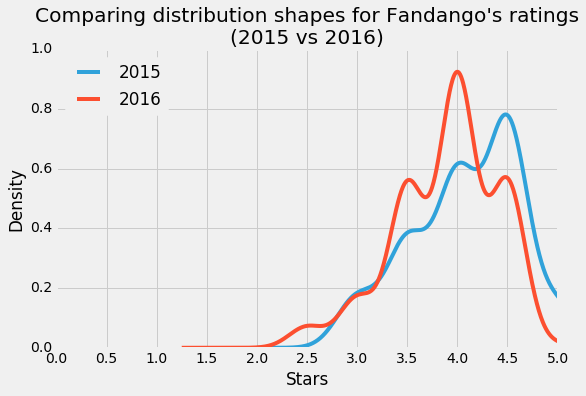

In [18]:
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8,5))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)",
          y = 1) # the `y` parameter pads the title upward
plt.xlabel('Stars')
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(arange(0,5.1,.5))
plt.show()

From the graph above we notice that :

  * Both distributions are strongly left skewed.
  * The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.

The left skew suggests that movie ratings on Fandango are mostly high and very high (above 4 out of 5 stars). 
The slight left shift of the 2016 distribution shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015. This is very helpsul for our analysis and helps to answer our research question.

### Comparing Relative Frequencies

While comparing the distributions with the help of the kernel density plots was a good start, we need to analyze more granular information.

We examine the frequency tables of the two distributions to analyze some numbers. Because the data sets have different numbers of movies, we normalize the tables and show percentages instead of row counts.

In [19]:
print('2015')
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

2015


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [20]:
print('2016')
fandango_2016['fandango'].value_counts(normalize = True).sort_index() * 100

2016


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

From the statistics above, we notice that in the 2016 data sets there are very few ratings with the highest scores (4.5 and 5), compared to those in 2015. In particular only about 0.5% of the movies received the highest rating of 5, compared to 2015 movies, when the percentage was almost 7%. In 2015 the lowest rating was 3, while in 2016 was 2.5. 

The ratings of 3.5 and 4 in the 2016 are higher in percentage as compared to 2015, therefore the direction of change might not be as clear as it seemed to be in the kernel density plots.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

### Determining the Direction of the Change

We'll take a couple of summary statistics to get a more precise picture about the direction of the difference. We'll take each distribution of movie ratings and compute its mean, median, and mode, and then compare these statistics to determine what they tell about the direction of the difference.

In [21]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0] # the output of Series.mode() is a bit uncommon
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


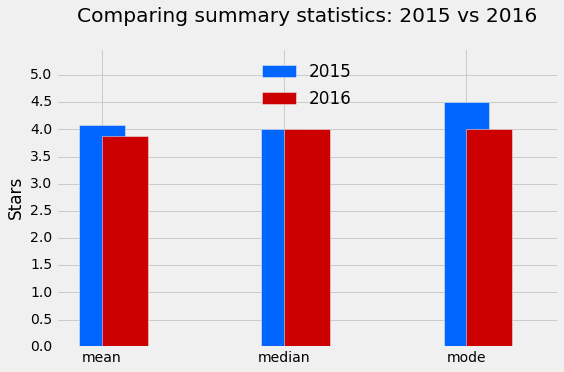

In [25]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

The median is almost the same for both distribution, while the mean and the mode for the 2015 movies are on average higher. We can there conculide that the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

### Conclusion

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We are not sure of the the reason for this change, but there are high chances that at least partially this can be attributed to Fandango fixing the biased rating system after Hickey's analysis.